# MNIST Image Classification with TensorFlow on Cloud ML Engine

This notebook demonstrates how to implement different image models on MNIST using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras).

## Learning Objectives
1. Understand how to build a Dense Neural Network (DNN) for image classification
2. Understand how to use dropout (DNN) for image classification
3. Understand how to use Convolutional Neural Networks (CNN)
4. Know how to deploy and use an image classifcation model using Google Cloud's [AI Platform](https://cloud.google.com/ai-platform/)

First things first. Configure the parameters below to match your own Google Cloud project details.

In [6]:
from datetime import datetime
import os

PROJECT = "your-project-id-here"  # REPLACE WITH YOUR PROJECT ID
BUCKET = "your-bucket-id-here"  # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1"  # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["IMAGE_URI"] = os.path.join("gcr.io", PROJECT, "mnist_models")

## Building a dynamic model

In the previous notebook, <a href="mnist_linear.ipynb">mnist_linear.ipynb</a>, we ran our code directly from the notebook. In order to run it on the AI Platform, it needs to be packaged as a python module.

The boilerplate structure for this module has already been set up in the folder `mnist_models`. The module lives in the sub-folder, `trainer`, and is designated as a python package with the empty `__init__.py` (`mnist_models/trainer/__init__.py`) file. It still needs the model and a trainer to run it, so let's make them.

Let's start with the trainer file first. This file parses command line arguments to feed into model.

In [ ]:
%%writefile mnist_models/trainer/task.py
import argparse
import json
import os
import sys

import model


def _parse_arguments(argv):
    """Parses command-line arguments."""
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--model_type',
        help='Which model type to use',
        type=str, default='linear')
    parser.add_argument(
        '--epochs',
        help='The number of epochs to train',
        type=int, default=10)
    parser.add_argument(
        '--steps_per_epoch',
        help='The number of steps per epoch to train',
        type=int, default=100)
    parser.add_argument(
        '--job-dir',
        help='Directory where to save the given model',
        type=str, default='mnist_models/')
    return parser.parse_known_args(argv)


def main():
    """Parses command line arguments and kicks off model training."""
    args = _parse_arguments(sys.argv[1:])[0]

    # Configure path for hyperparameter tuning.
    trial_id = json.loads(
        os.environ.get('TF_CONFIG', '{}')).get('task', {}).get('trial', '')
    output_path = args.job_dir if not trial_id else args.job_dir + '/'

    model_layers = model.get_layers(args.model_type)
    image_model = model.build_model(model_layers, args.job_dir)
    model_history = model.train_and_evaluate(
        image_model, args.epochs, args.steps_per_epoch, args.job_dir)


if __name__ == '__main__':
    main()


Next, let's group non-model functions into a util file to keep the model file simple. We'll copy over the `scale` and `load_dataset` functions from the previous lab.

In [ ]:
%%writefile mnist_models/trainer/util.py
import tensorflow as tf


def scale(image, label):
    """Scales images from a 0-255 int range to a 0-1 float range"""
    image = tf.cast(image, tf.float32)
    image /= 255
    image = tf.expand_dims(image, -1)
    return image, label


def load_dataset(
        data, training=True, buffer_size=5000, batch_size=100, nclasses=10):
    """Loads MNIST dataset into a tf.data.Dataset"""
    (x_train, y_train), (x_test, y_test) = data
    x = x_train if training else x_test
    y = y_train if training else y_test
    # One-hot encode the classes
    y = tf.keras.utils.to_categorical(y, nclasses)
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(scale).batch(batch_size)
    if training:
        dataset = dataset.shuffle(buffer_size).repeat()
    return dataset


Finally, let's code the models! The [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras) accepts an array of [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) into a [model object](https://www.tensorflow.org/api_docs/python/tf/keras/Model), so we can create a dictionary of layers based on the different model types we want to use. The below file has two functions: `get_layers` and `create_and_train_model`. We will build the structure of our model in `get_layers`. Last but not least, we'll copy over the training code from the previous lab into `train_and_evaluate`.

**TODO 1**: Define the Keras layers for a DNN model   
**TODO 2**: Define the Keras layers for a dropout model  
**TODO 3**: Define the Keras layers for a CNN model  

Hint: These models progressively build on each other. Look at the imported `tensorflow.keras.layers` modules and the default values for the variables defined in `get_layers` for guidance.

In [ ]:
%%writefile mnist_models/trainer/model.py
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)

import util


# Image Variables
WIDTH = 28
HEIGHT = 28


def get_layers(
        model_type,
        nclasses=10,
        hidden_layer_1_neurons=400,
        hidden_layer_2_neurons=100,
        dropout_rate=0.25,
        num_filters_1=64,
        kernel_size_1=3,
        pooling_size_1=2,
        num_filters_2=32,
        kernel_size_2=3,
        pooling_size_2=2):
    """Constructs layers for a keras model based on a dict of model types."""
    model_layers = {
        'linear': [
            Flatten(),
            Dense(nclasses),
            Softmax()
        ],
        'dnn': [
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dense(nclasses),
            Softmax()
        ],
        'dnn_dropout': [
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ],
        'cnn': [
            Conv2D(num_filters_1, kernel_size=kernel_size_1,
                   activation='relu', input_shape=(WIDTH, HEIGHT, 1)),
            MaxPooling2D(pooling_size_1),
            Conv2D(num_filters_2, kernel_size=kernel_size_2,
                   activation='relu'),
            MaxPooling2D(pooling_size_2),
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ]
    }
    return model_layers[model_type]


def build_model(layers, output_dir):
    """Compiles keras model for image classification."""
    model = Sequential(layers)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def train_and_evaluate(model, num_epochs, steps_per_epoch, output_dir):
    """Compiles keras model and loads data into it for training."""
    mnist = tf.keras.datasets.mnist.load_data()
    train_data = util.load_dataset(mnist)
    validation_data = util.load_dataset(mnist, training=False)

    callbacks = []
    if output_dir:
        tensorboard_callback = TensorBoard(log_dir=output_dir)
        callbacks = [tensorboard_callback]

    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=2,
        callbacks=callbacks)

    if output_dir:
        export_path = os.path.join(output_dir, 'keras_export')
        model.save(export_path, save_format='tf')

    return history


## Local Training

With everything set up, let's run locally to test the code. We can run it as a python module locally first using the command line.

The below cell transfers some of our variables to the command line as well as create a job directory including a timestamp. This is where our model and tensorboard data will be stored.

In [21]:
current_time = datetime.now().strftime("%y%m%d_%H%M%S")
model_type = 'cnn'

os.environ["MODEL_TYPE"] = model_type
os.environ["JOB_DIR"] = "mnist_trained/models/{}_{}/".format(
    model_type, current_time)

The cell below runs the local version of the code. The epochs and steps_per_epoch flag can be changed to run for longer or shorther, as defined in our `mnist_models/trainer/task.py` file.

In [22]:
%%bash
mkdir $JOB_DIR
python3 mnist_models/trainer/task.py \
    --job-dir=$JOB_DIR \
    --epochs=5 \
    --steps_per_epoch=50 \
    --model_type=$MODEL_TYPE

Train for 50 steps, validate for 100 steps
Epoch 1/5
50/50 - 12s - loss: 1.0242 - accuracy: 0.6752 - val_loss: 0.3151 - val_accuracy: 0.9078
Epoch 2/5
50/50 - 6s - loss: 0.3248 - accuracy: 0.9060 - val_loss: 0.1702 - val_accuracy: 0.9518
Epoch 3/5
50/50 - 5s - loss: 0.1940 - accuracy: 0.9408 - val_loss: 0.1452 - val_accuracy: 0.9554
Epoch 4/5
50/50 - 5s - loss: 0.1684 - accuracy: 0.9502 - val_loss: 0.1092 - val_accuracy: 0.9659
Epoch 5/5
50/50 - 5s - loss: 0.1305 - accuracy: 0.9624 - val_loss: 0.0912 - val_accuracy: 0.9717


2019-11-29 22:10:22.403634: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2019-11-29 22:10:22.410621: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2019-11-29 22:10:22.410987: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5599976325f0 executing computations on platform Host. Devices:
2019-11-29 22:10:22.411020: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2019-11-29 22:10:22.411324: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2019-11-29 22:10:29.551629: I tensorflow/core/profiler/lib/profiler_session.c

Let's check out how the model did in tensorboard and confirm that it's good to go before kicking it off to train on the cloud. If running on a Deep Learning VM, open the folder corresponding to the `--job-dir` above. Then, go to File > New Launcher. Click on Tensorboard under "Other".

If runnining locally, the following command can be run in a terminal:

`tensorboard --logdir=<path-to-data-directory>`

## Training on the cloud

Since we're using an unreleased version of TensorFlow on AI Platform, we can instead use a [Deep Learning Container](https://cloud.google.com/ai-platform/deep-learning-containers/docs/overview) in order to take advantage of libraries and applications not normally packaged with AI Platform. Below is a simple [Dockerlife](https://docs.docker.com/engine/reference/builder/) which copies our code to be used in a TF2 environment.

In [4]:
%%writefile mnist_models/Dockerfile
FROM gcr.io/deeplearning-platform-release/tf2-cpu
COPY mnist_models/trainer /mnist_models/trainer
ENTRYPOINT ["python3", "mnist_models/trainer/task.py"]

Writing mnist_models/Dockerfile


The below command builds the image and ships it off to Google Cloud so it can be used for AI Platform. When built, it will show up [here](http://console.cloud.google.com/gcr) with the name `mnist_models`. ([Click here](https://console.cloud.google.com/cloud-build) to enable Cloud Build)

In [7]:
!docker build -f mnist_models/Dockerfile -t $IMAGE_URI ./

Sending build context to Docker daemon  995.8kB
Step 1/3 : FROM gcr.io/deeplearning-platform-release/tf2-cpu
latest: Pulling from deeplearning-platform-release/tf2-cpu

02085707: Pulling fs layer 
5509d51d: Pulling fs layer 
9fe70a46: Pulling fs layer 
e1789921: Pulling fs layer 
902c87a2: Pulling fs layer 
0edf82af: Pulling fs layer 
cc7a0819: Pulling fs layer 
778cb300: Pulling fs layer 
a31a8af6: Pulling fs layer 
5d29f5ab: Pulling fs layer 
a06da4d7: Pulling fs layer 
05cedc93: Pulling fs layer 
45cced6f: Pulling fs layer 
e6aa5553: Pulling fs layer 
54118978: Pulling fs layer 
626a77b0: Pulling fs layer 
e6add651: Pulling fs layer 
a4f2b51b: Pulling fs layer 
b8b2c13c: Pulling fs layer 
12577c37: Pulling fs layer 
ceba06f1: Pull complete 0.4kB/100.4kBB21ADigest: sha256:88ae24914e15f2df11a03486668e9051ca85b65f8577358e7d965ce6a146f217
Status: Downloaded newer image for gcr.io/deeplearning-platform-release/tf2-cpu:latest
 ---> e493f17c90d0
Step 2/3 : COPY mnist_models/trainer /mnist_

In [8]:
!docker push $IMAGE_URI

The push refers to repository [gcr.io/qwiklabs-gcp-ml-489e10787faf/mnist_models]

0caff7fd: Preparing 
581319d1: Preparing 
d92bb97d: Preparing 
218cebaf: Preparing 
750480c5: Preparing 
1a04733b: Preparing 
67e0ba2d: Preparing 
50747c65: Preparing 
36f9bda1: Preparing 
7efe6784: Preparing 
27b0e386: Preparing 
4689ea9a: Preparing 
971c1728: Preparing 
63e1ea3e: Preparing 
2b9c88ab: Preparing 
db0181d2: Preparing 
197acff6: Preparing 
87810c15: Preparing 
e11ab4a2: Preparing 
13bce073: Preparing 
e43028b3: Preparing 
caff7fd: Pushed lready exists 2kBlatest: digest: sha256:ef45e3e0350a0ca4fcdcf90400529bb0c4957dbd326b1999fd44be4b4eca244b size: 4925


Finally, we can kickoff the [AI Platform training job](https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training). We can pass in our docker image using the `master-image-uri` flag.

In [64]:
current_time = datetime.now().strftime("%y%m%d_%H%M%S")
model_type = 'cnn'

os.environ["MODEL_TYPE"] = model_type
os.environ["JOB_DIR"] = "gs://{}/mnist_{}_{}/".format(
    BUCKET, model_type, current_time)
os.environ["JOB_NAME"] = "mnist_{}_{}".format(
    model_type, current_time)

In [23]:
%%bash
echo $JOB_DIR $REGION $JOB_NAME
gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket=gs://$BUCKET \
    --region=$REGION \
    --master-image-uri=$IMAGE_URI \
    --scale-tier=BASIC_GPU \
    --job-dir=$JOB_DIR \
    -- \
    --model_type=$MODEL_TYPE

Can't wait to see the results? Run the code below and copy the output into the [Google Cloud Shell](https://console.cloud.google.com/home/dashboard?cloudshell=true) to follow along with TensorBoard. Look at the web preview on port 6006.

In [ ]:
!echo "tensorboard --logdir $JOB_DIR"

## Deploying and predicting with model

Once you have a model you're proud of, let's deploy it! All we need to do is give AI Platform the location of the model. Below uses the keras export path of the previous job, but `${JOB_DIR}keras_export/` can always be changed to a different path.

Even though we're using a 1.14 runtime, it's compatable with TF2 exported models. Phew!

Uncomment the delete commands below if you are getting an "already exists error" and want to deploy a new model.

In [80]:
%%bash
MODEL_NAME="mnist"
MODEL_VERSION=${MODEL_TYPE}
MODEL_LOCATION=${JOB_DIR}keras_export/
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#yes | gcloud ai-platform versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#yes | gcloud ai-platform models delete ${MODEL_NAME}
gcloud ai-platform models create ${MODEL_NAME} --regions $REGION
gcloud ai-platform versions create ${MODEL_VERSION} \
    --model ${MODEL_NAME} \
    --origin ${MODEL_LOCATION} \
    --framework tensorflow \
    --runtime-version=1.14

gs://asl-testing/mnist_cnn_191110_232052/keras_export/


Creating version (this might take a few minutes)......
.......................................................................................................................................................................................................................................................................................................done.


To predict with the model, let's take one of the example images.

**TODO 4**: Write a `.json` file with image data to send to an AI Platform deployed model

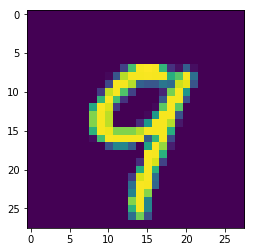

In [81]:
import json, codecs
import tensorflow as tf
import matplotlib.pyplot as plt
from mnist_models.trainer import util

HEIGHT = 28
WIDTH = 28
IMGNO = 12

mnist = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist
test_image = x_test[IMGNO]

jsondata = test_image.reshape(HEIGHT, WIDTH, 1).tolist()
json.dump(jsondata, codecs.open("test.json", "w", encoding = "utf-8"))
plt.imshow(test_image.reshape(HEIGHT, WIDTH));

Finally, we can send it to the prediction service. The output will have a 1 in the index of the corresponding digit it is predicting. Congrats! You've completed the lab!

In [82]:
%%bash
gcloud ai-platform predict \
    --model=mnist \
    --version=${MODEL_TYPE} \
    --json-instances=./test.json

SOFTMAX_3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.